 # 🗼⚡**Energy Consumption Modeling, Forecasting and Causal Inference For Business Understanding**

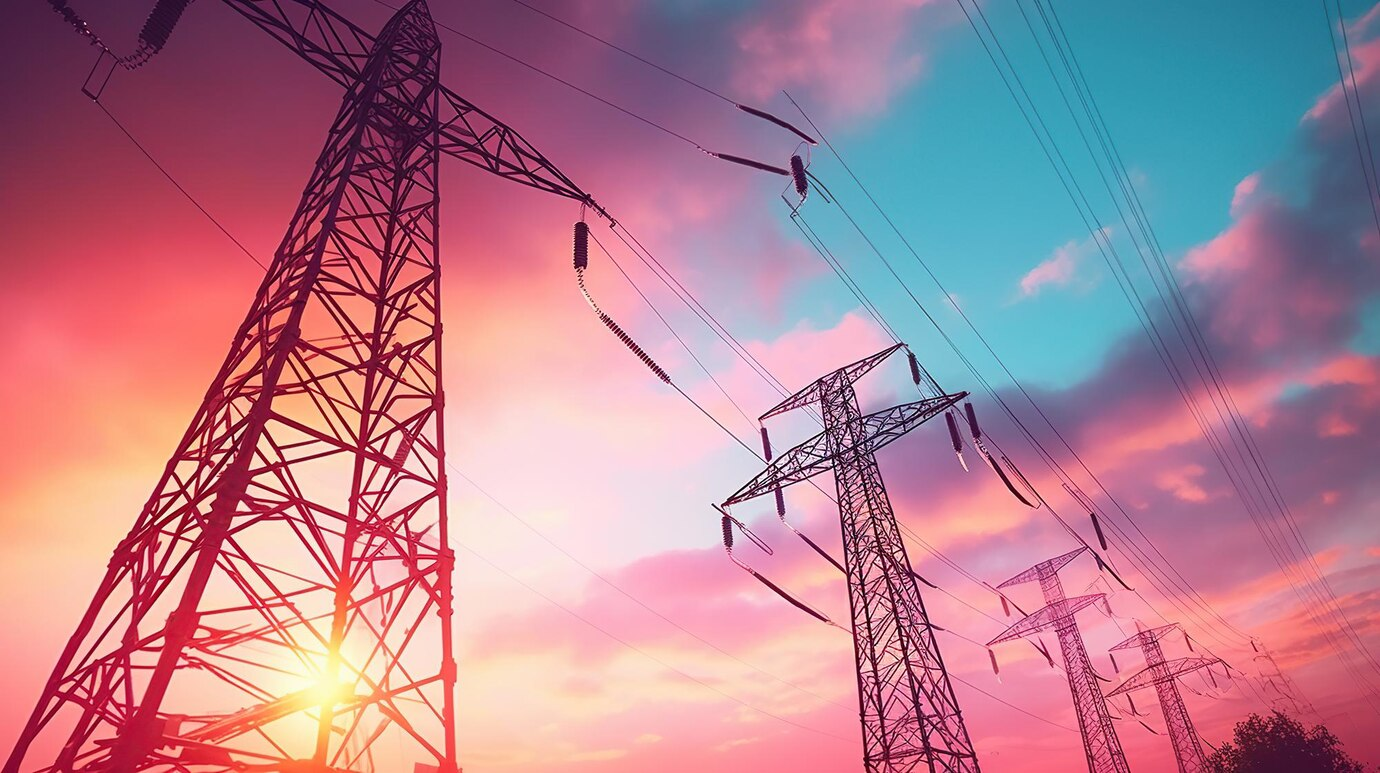

# Dataset
> PJM Hourly Energy Consumption Data
PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

There are a total of 12 main datasets with features **date** and **energy consumption** in MegaWatts

The 12 main datasets include:
1. AEP
2. COMED
3. DAYTON
4. DEOK
5. DOM
6. DUQ
7. EKPC
8. FE
9. NI
10. PJM
11. PJME
12. PJMW

**Dataset Link**: [Hourly Energy Consumption Dataset](https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption
)

# Project Management Decision

>  In order to build this I will follow the CRISP-DM approach of project management.

>  The reasons for doing so are as follows:

- This project has a clear objective, where I will build forecast models to understand demand and derive causal inferences to develop business understanding.
- The project is an end-to-end pipline with documentation so that it allows easy traceability and reproduciability in future.
- There is minimal stakeholder involvement as it is an individual project

> The diagram below shows the important blocks required to manage and build a project that follows CRISP-DM strategy:

![SVG Example](./images/crisp-dm_diagram2.svg)


## 🚨 1. Business Understanding
> ✅ From  a business perspective we want to ask the question:
  - Q1. Can we forecast energy demands upto a certain number of time steps into the future?

> ✅ Importance of exploring this business question:
  - Planning and regulations to meet future demands
  - Scaling and equipment demands
  - Risk analysis

In [1]:
!pip install Boruta

# Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import holidays

from google.colab import files


from IPython.core.display  import HTML
from IPython.display       import Image
from datetime              import date
from tabulate              import tabulate
from scipy.stats           import chi2_contingency

from sklearn.ensemble      import RandomForestRegressor

from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.ensemble      import RandomForestRegressor
import xgboost as xgb

from boruta                import BorutaPy


import random
import warnings
warnings.filterwarnings( 'ignore' )

## Upload data from device

In [4]:
# file upload from local drive
uploaded = files.upload()

Saving AEP_hourly.csv to AEP_hourly.csv
Saving COMED_hourly.csv to COMED_hourly.csv
Saving DAYTON_hourly.csv to DAYTON_hourly.csv
Saving DEOK_hourly.csv to DEOK_hourly.csv
Saving DOM_hourly.csv to DOM_hourly.csv
Saving DUQ_hourly.csv to DUQ_hourly.csv
Saving EKPC_hourly.csv to EKPC_hourly.csv
Saving FE_hourly.csv to FE_hourly.csv
Saving NI_hourly.csv to NI_hourly.csv
Saving pjm_hourly_est.csv to pjm_hourly_est.csv
Saving PJM_Load_hourly.csv to PJM_Load_hourly.csv
Saving PJME_hourly.csv to PJME_hourly.csv
Saving PJMW_hourly.csv to PJMW_hourly.csv


# Data Loading

In [5]:
aep = pd.read_csv( '/content/AEP_hourly.csv', low_memory=False )
comed = pd.read_csv( '/content/COMED_hourly.csv', low_memory=False )
dayton = pd.read_csv( '/content/DAYTON_hourly.csv', low_memory=False )
deok = pd.read_csv( '/content/DEOK_hourly.csv', low_memory=False )
dom = pd.read_csv( '/content/DOM_hourly.csv', low_memory=False )
duq = pd.read_csv( '/content/DUQ_hourly.csv', low_memory=False )
ekpc = pd.read_csv( '/content/EKPC_hourly.csv', low_memory=False )
fe = pd.read_csv( '/content/FE_hourly.csv', low_memory=False )
ni = pd.read_csv( '/content/NI_hourly.csv', low_memory=False )
pjm = pd.read_csv( '/content/PJM_Load_hourly.csv', low_memory=False )
pjme = pd.read_csv( '/content/PJME_hourly.csv', low_memory=False )
pjmw = pd.read_csv( '/content/PJMW_hourly.csv', low_memory=False )

## Concatenate the data into one consolidated dataset with information on all companies and their respective energy consumptions:



> ▶ Create an extra column with company names




In [6]:
aep['electric_company'] = 'AEP'
comed['electric_company'] = 'COMED'
dayton['electric_company'] = 'DAYTON'
deok['electric_company'] = 'DEOK'
dom['electric_company'] = 'DOM'
duq['electric_company'] = 'DUQ'
ekpc['electric_company'] = 'EKPC'
fe['electric_company'] = 'FE'
ni['electric_company'] = 'NI'
pjm['electric_company'] = 'PJM'
pjme['electric_company'] = 'PJME'
pjmw['electric_company'] = 'PJMW'

> ▶ The energy consumption column name should be same in all the dataframes, therefore it has to be renamed

In [7]:
aep = aep.rename( columns={'AEP_MW': 'mw_energy'} )
comed = comed.rename( columns={'COMED_MW': 'mw_energy'} )
dayton = dayton.rename( columns={'DAYTON_MW': 'mw_energy'} )
deok = deok.rename( columns={'DEOK_MW': 'mw_energy'} )
dom = dom.rename( columns={'DOM_MW': 'mw_energy'} )
duq = duq.rename( columns={'DUQ_MW': 'mw_energy'} )
ekpc = ekpc.rename( columns={'EKPC_MW': 'mw_energy'} )
fe = fe.rename( columns={'FE_MW': 'mw_energy'} )
ni = ni.rename( columns={'NI_MW': 'mw_energy'} )
pjm = pjm.rename( columns={'PJM_Load_MW': 'mw_energy'} )
pjme = pjme.rename( columns={'PJME_MW': 'mw_energy'} )
pjmw = pjmw.rename( columns={'PJMW_MW': 'mw_energy'} )

In [8]:
# Concatenating
df_main = pd.concat( [aep, comed, dayton, deok, dom, duq, ekpc, fe, ni, pjm, pjme, pjmw] )
df_main.sample(8)

,Datetime,mw_energy,electric_company
65568,2012-03-10 17:00:00,9165.0,DOM
71678,2010-10-27 09:00:00,32906.0,PJME
12874,2013-07-14 14:00:00,4110.0,DEOK
3460,2002-08-09 06:00:00,25456.0,PJME
18695,2013-06-15 04:00:00,5647.0,FE
8330,2012-08-20 05:00:00,5832.0,FE
26982,2005-12-03 13:00:00,33569.0,PJME
17686,2007-08-26 03:00:00,10355.0,DOM


# 📊 2. Data Understanding

> ▶ Data shape and primary information on the data

In [9]:
print(df_main.shape)
df_main.info()

(1090167, 3)
<class 'pandas.core.frame.DataFrame'>
Index: 1090167 entries, 0 to 143205
Data columns (total 3 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Datetime          1090167 non-null  object 
 1   mw_energy         1090167 non-null  float64
 2   electric_company  1090167 non-null  object 
dtypes: float64(1), object(2)
memory usage: 33.3+ MB


In [10]:
# Creating a copy of the main dataframe
df_anlaysis = df_main.copy()

In [11]:
# Column renaming
df_anlaysis.rename(columns={'Datetime':'datetime'}, inplace=True)
print(df_anlaysis.columns)

Index(['datetime', 'mw_energy', 'electric_company'], dtype='object')


In [12]:
# Understanding datatypes
df_anlaysis.dtypes

,0
datetime,object
mw_energy,float64
electric_company,object


> ▶ Convert *'datetime'* column from **string object** dtype to **datetime object** dtype   

In [13]:
df_anlaysis['datetime'] = pd.to_datetime(df_anlaysis['datetime'])

In [14]:
# Ensuring datatype transform
df_anlaysis.dtypes

,0
datetime,datetime64[ns]
mw_energy,float64
electric_company,object


 ## 📉 3. Data Preparation

### 🔎 Checking Missing and Null Values

In [15]:
df_anlaysis.isna().sum()

,0
datetime,0
mw_energy,0
electric_company,0


In [16]:
df_anlaysis.isnull().sum()

,0
datetime,0
mw_energy,0
electric_company,0


> 💡 No imputation required for the consolidated dataset as it doesnot have any missing values

### 🔬📊  Descriptive Statistics

> ▶ Splitting dataframe into numerical and categorical attributes

In [17]:
num_features = df_anlaysis.select_dtypes(include=['float64'])
cat_features = df_anlaysis.select_dtypes(exclude=['float64', 'datetime64[ns]'])

In [18]:
# sample of numerical features
num_features.sample()


,mw_energy
895,8774.0


In [19]:
# sample of categorical features
cat_features.sample()

,electric_company
12274,PJME


### 📈 Numerical Statitics: Central tendencies, dispersion, skewness and kurtosis

In [20]:
# Central Tendencies
## Mean
num_mean = pd.DataFrame(num_features.apply(np.mean)).T
## Median
num_median = pd.DataFrame(num_features.apply(np.median)).T

# Dispersion
num_std = pd.DataFrame( num_features.apply( np.std ) ).T
num_min = pd.DataFrame( num_features.apply( min ) ).T
num_max = pd.DataFrame( num_features.apply( max ) ).T
num_range = pd.DataFrame( num_features.apply( lambda x: x.max() - x.min() ) ).T
num_skew = pd.DataFrame( num_features.apply( lambda x: x.skew() ) ).T
num_kurtosis = pd.DataFrame( num_features.apply( lambda x: x.kurtosis() ) ).T

# concatenate stats
num_concat = pd.concat([num_min, num_max, num_range, num_median, num_mean, num_std, num_skew, num_kurtosis]).T.reset_index()
num_concat.columns = (['Feature', 'min', 'max', 'range', 'median', 'mean', 'std', 'skew', 'kurtosis'])

In [21]:
num_concat

,Feature,min,max,range,median,mean,std,skew,kurtosis
0,mw_energy,0.0,62009.0,62009.0,8217.0,11209.58865,10534.394704,1.356423,1.198281


> ▶ FUNCTION: Jupyter Notebook Settings

In [67]:
# jupyter settings function
def jupyter_settings():
    %matplotlib inline
    %pylab inline

    plt.style.use( 'fivethirtyeight' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )

    sns.set()

In [68]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


<Axes: xlabel='mw_energy', ylabel='Density'>

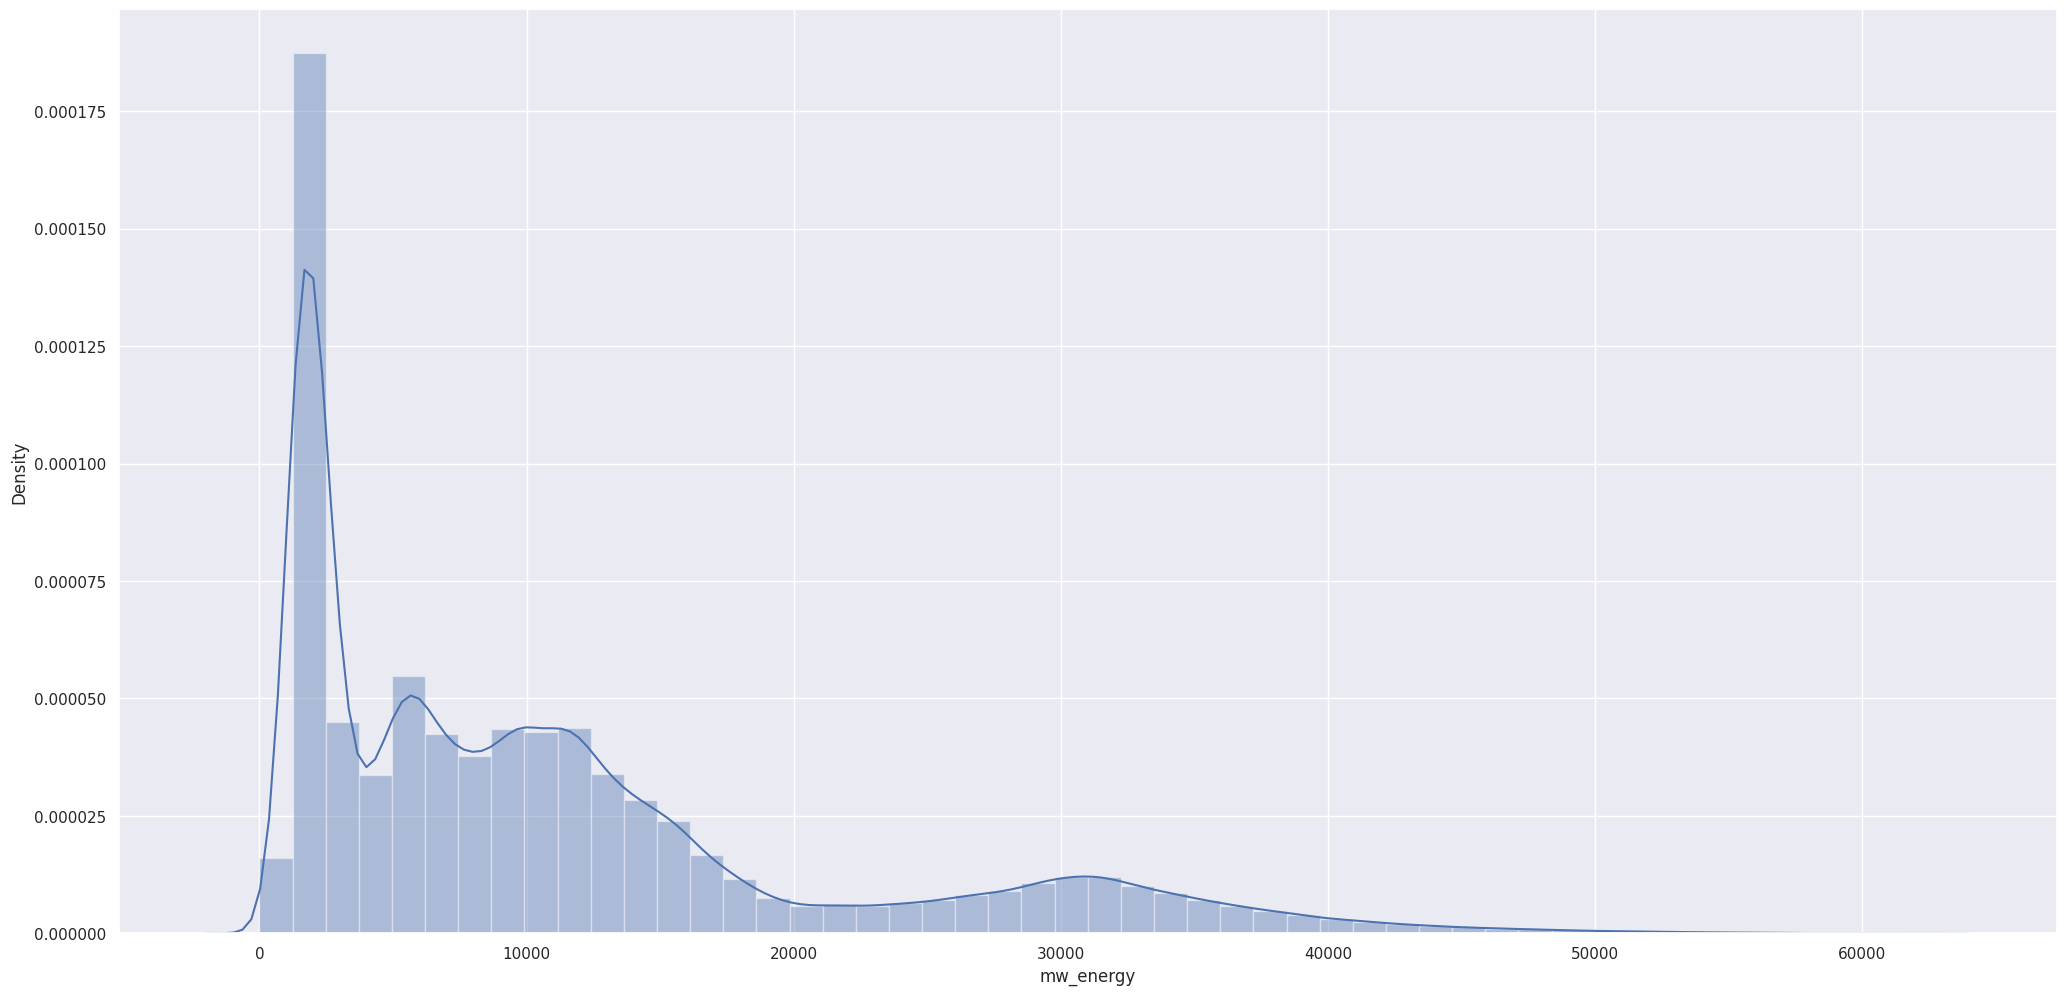

In [24]:
# Distribution plot of energy consumption
sns.distplot(df_anlaysis['mw_energy'])

### 🆎 Categorical Statistics observing energy consumption per company

In [25]:
cat_features.apply( lambda x: x.unique().shape[0] )

,0
electric_company,12


<Axes: xlabel='electric_company', ylabel='mw_energy'>

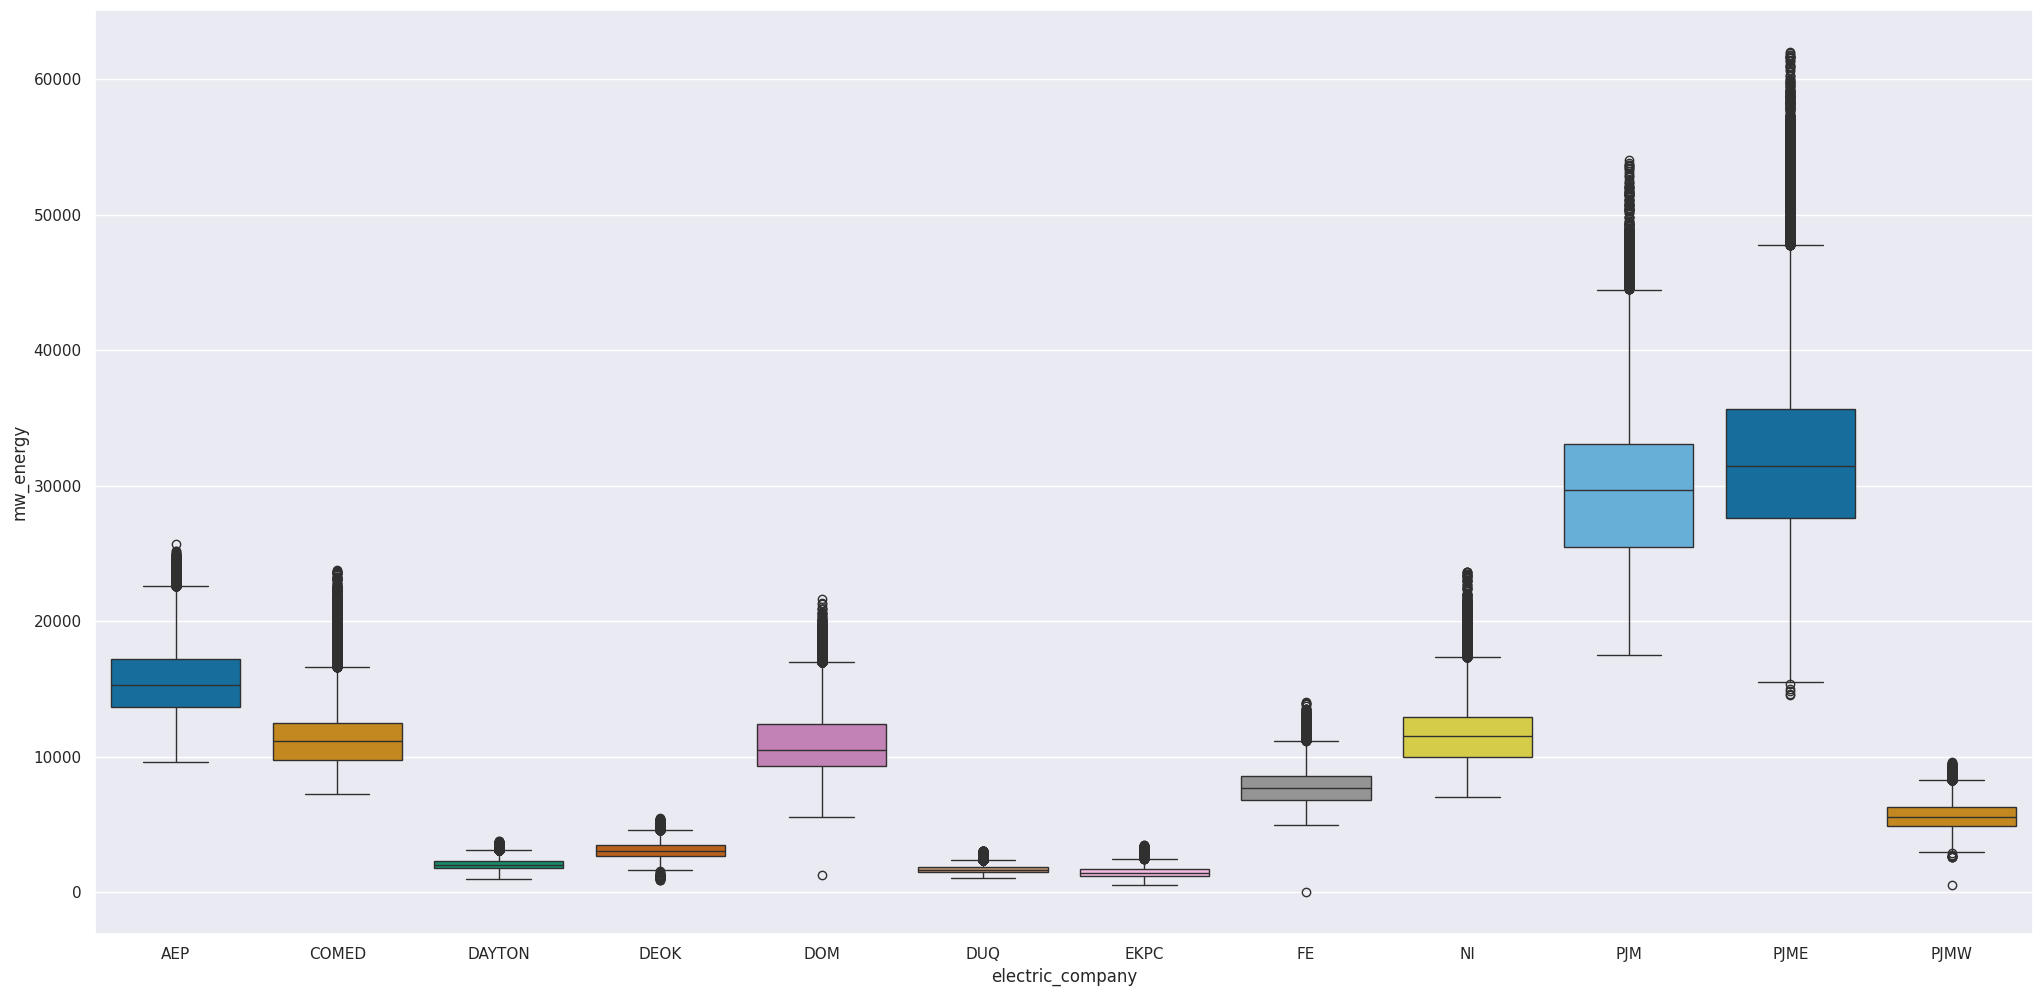

In [26]:
# box plot of energy consumption recorded by each company
# Sample palette with different colors for each company

sns.boxplot( x= 'electric_company', y='mw_energy' , data=df_anlaysis, palette="colorblind" )

### 👷 Feature Engineering
>  - Researching energy consumption literature revealed the various factors that can affect energy consumption over time
>  - We will try to probe into some of these aspects to reason business decision making
>  - Below I narrow down some critical factors in the form of a mindmap


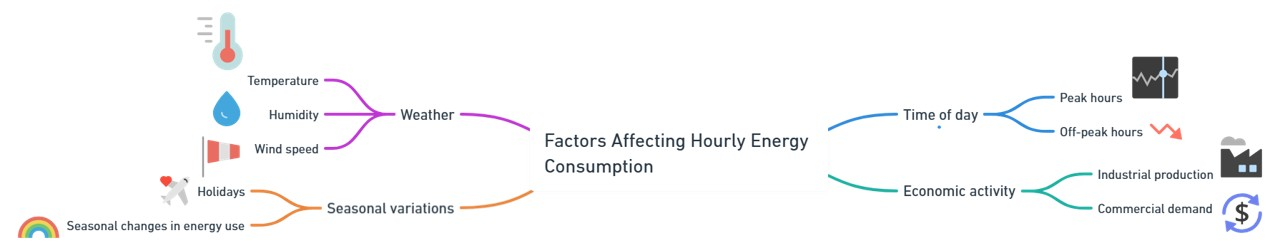

In [27]:
# copying the processed dataframe
df_feature_eng = df_anlaysis.copy()

> ### Keeping the factors narrowed down the following features will be extarcted:

> * Date
* Year
* Month
* Hour of the Day
* Seasons
* Holidays


In [28]:
# Date
df_feature_eng['date'] = df_feature_eng['datetime'].dt.date

# Year
df_feature_eng['year'] = df_feature_eng['datetime'].dt.year

# Month
df_feature_eng['month'] = df_feature_eng['datetime'].dt.month

# Hour
df_feature_eng['hour'] = df_feature_eng['datetime'].dt.hour

# Seasons Time Segments
# Winter -> December (12), January (01) and February (02);
# Spring -> March (03), April (04) and May (05);
# Summer -> Jun (06), July (07) and August (08);
# Autumn -> September (09), October (10) and November (11).
df_feature_eng['season'] = df_feature_eng['datetime'].apply( lambda x: 'Winter' if x.month == 12 or x.month == 1 or x.month == 2 else 'Spring' if  x.month == 3 or x.month == 4 or x.month == 5 else 'Summer' if  x.month == 6 or x.month == 7 or x.month == 8 else 'Autumn' if  x.month == 9 or x.month == 10 or x.month == 11 else '')

# US Federal Holidays
df_feature_eng['holidays'] = df_feature_eng['datetime'].apply( lambda x: 'Holiday' if x in holidays.US() else 'Holiday' if x + datetime.timedelta(days=1) in holidays.US() else 'Normal day' )


# Day of week:

# 0 - Monday
# 1 - Tuesday
# 2 - Wednesday
# 3 - Thursday
# 4 - Friday
# 5 - Saturday
# 6 - Sunday
df_feature_eng['day_of_week'] = df_feature_eng['datetime'].dt.weekday

In [29]:
# datatype check post feature engineering
df_feature_eng.dtypes

,0
datetime,datetime64[ns]
mw_energy,float64
electric_company,object
date,object
year,int32
month,int32
hour,int32
season,object
holidays,object
day_of_week,int32


In [30]:
# Changing 'date' column to datetime object
df_feature_eng['date'] = pd.to_datetime(df_feature_eng['date'])

In [31]:
df_feature_eng.dtypes

,0
datetime,datetime64[ns]
mw_energy,float64
electric_company,object
date,datetime64[ns]
year,int32
month,int32
hour,int32
season,object
holidays,object
day_of_week,int32


In [34]:
df_feature_eng.head()

,datetime,mw_energy,electric_company,date,year,month,hour,season,holidays,day_of_week
0,2004-12-31 01:00:00,13478.0,AEP,2004-12-31,2004,12,1,Winter,Holiday,4
1,2004-12-31 02:00:00,12865.0,AEP,2004-12-31,2004,12,2,Winter,Holiday,4
2,2004-12-31 03:00:00,12577.0,AEP,2004-12-31,2004,12,3,Winter,Holiday,4
3,2004-12-31 04:00:00,12517.0,AEP,2004-12-31,2004,12,4,Winter,Holiday,4
4,2004-12-31 05:00:00,12670.0,AEP,2004-12-31,2004,12,5,Winter,Holiday,4


In [41]:
df_feature_eng.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1090167 entries, 0 to 143205
Data columns (total 10 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   datetime          1090167 non-null  datetime64[ns]
 1   mw_energy         1090167 non-null  float64       
 2   electric_company  1090167 non-null  object        
 3   date              1090167 non-null  datetime64[ns]
 4   year              1090167 non-null  int32         
 5   month             1090167 non-null  int32         
 6   hour              1090167 non-null  int32         
 7   season            1090167 non-null  object        
 8   holidays          1090167 non-null  object        
 9   day_of_week       1090167 non-null  int32         
dtypes: datetime64[ns](2), float64(1), int32(4), object(3)
memory usage: 74.9+ MB


In [46]:
num_features2 = df_feature_eng.select_dtypes( include=['int64', 'int32','float64'] )
cat_features2 = df_feature_eng.select_dtypes( exclude=['int64','int32', 'float64', 'datetime64[ns]'] )

In [47]:
num_features2.dtypes

,0
mw_energy,float64
year,int32
month,int32
hour,int32
day_of_week,int32


In [48]:
cat_features2.dtypes

,0
electric_company,object
season,object
holidays,object


In [44]:
df_feature_eng.sample(10).T

,29695,28532,133629,23029,1095,94245,119408,43080,85112,99339
datetime,2008-04-13 14:00:00,2008-09-28 04:00:00,2017-10-03 22:00:00,2004-02-16 20:00:00,2011-11-16 16:00:00,2016-12-01 16:00:00,2018-03-19 05:00:00,2009-01-31 11:00:00,2011-01-15 06:00:00,2016-12-02 00:00:00
mw_energy,8878.0,1211.0,28463.0,7465.0,7975.0,9625.0,1725.0,1752.0,5936.0,1944.0
electric_company,DOM,DUQ,PJME,PJMW,FE,DOM,DAYTON,DUQ,PJMW,DAYTON
date,2008-04-13 00:00:00,2008-09-28 00:00:00,2017-10-03 00:00:00,2004-02-16 00:00:00,2011-11-16 00:00:00,2016-12-01 00:00:00,2018-03-19 00:00:00,2009-01-31 00:00:00,2011-01-15 00:00:00,2016-12-02 00:00:00
year,2008,2008,2017,2004,2011,2016,2018,2009,2011,2016
month,4,9,10,2,11,12,3,1,1,12
hour,14,4,22,20,16,16,5,11,6,0
season,Spring,Autumn,Autumn,Winter,Autumn,Winter,Spring,Winter,Winter,Winter
holidays,Normal day,Normal day,Normal day,Holiday,Normal day,Normal day,Normal day,Normal day,Normal day,Normal day
day_of_week,6,6,1,0,2,3,0,5,5,4


In [49]:
df_feature_eng.head()

,datetime,mw_energy,electric_company,date,year,month,hour,season,holidays,day_of_week
0,2004-12-31 01:00:00,13478.0,AEP,2004-12-31,2004,12,1,Winter,Holiday,4
1,2004-12-31 02:00:00,12865.0,AEP,2004-12-31,2004,12,2,Winter,Holiday,4
2,2004-12-31 03:00:00,12577.0,AEP,2004-12-31,2004,12,3,Winter,Holiday,4
3,2004-12-31 04:00:00,12517.0,AEP,2004-12-31,2004,12,4,Winter,Holiday,4
4,2004-12-31 05:00:00,12670.0,AEP,2004-12-31,2004,12,5,Winter,Holiday,4


In [50]:
df_feature_eng.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1090167 entries, 0 to 143205
Data columns (total 10 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   datetime          1090167 non-null  datetime64[ns]
 1   mw_energy         1090167 non-null  float64       
 2   electric_company  1090167 non-null  object        
 3   date              1090167 non-null  datetime64[ns]
 4   year              1090167 non-null  int32         
 5   month             1090167 non-null  int32         
 6   hour              1090167 non-null  int32         
 7   season            1090167 non-null  object        
 8   holidays          1090167 non-null  object        
 9   day_of_week       1090167 non-null  int32         
dtypes: datetime64[ns](2), float64(1), int32(4), object(3)
memory usage: 74.9+ MB


### 🔍 📊 Exploratory Data Analysis

In [51]:
df_eda = df_feature_eng.copy()

###  🔦 EDA - Part 1: Univariate Analysis
-  Response Variable distribution
-  Numerical Variables distribution
-  categorical Variable Analysis

<Axes: xlabel='mw_energy'>

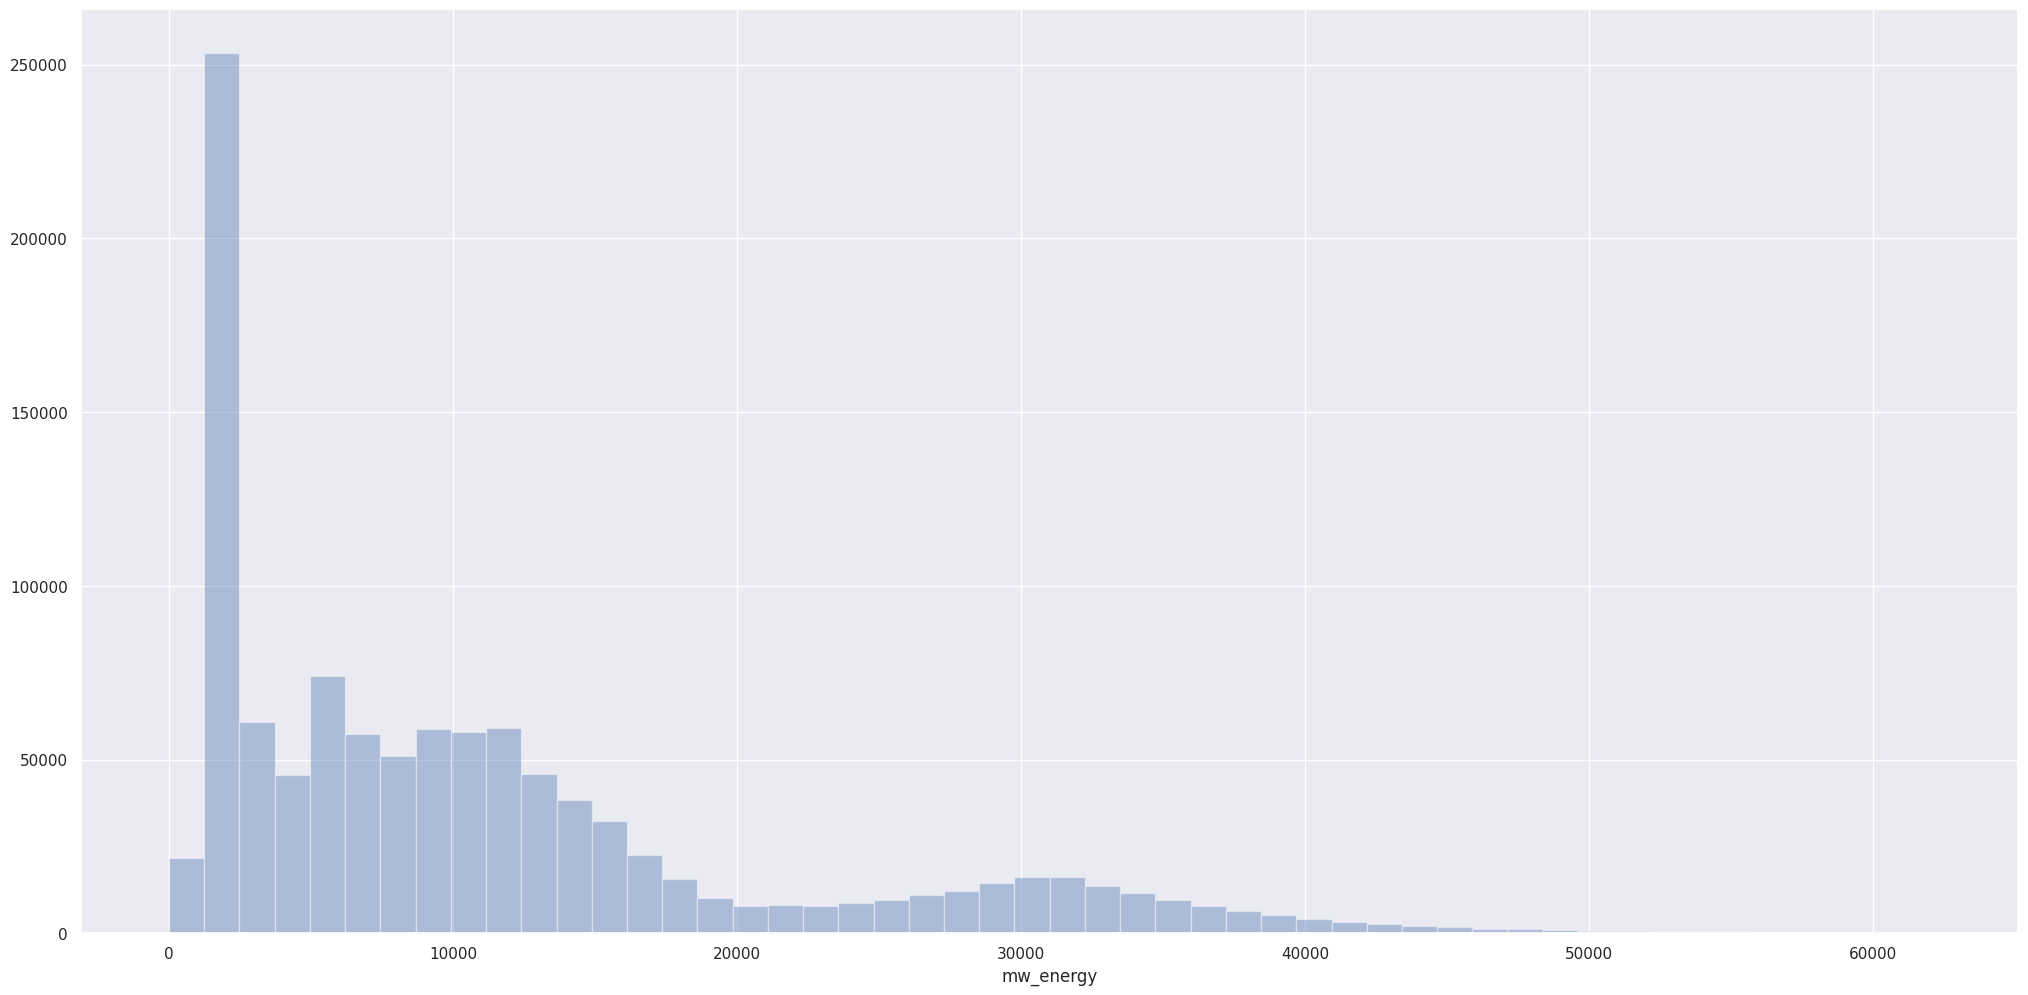

In [52]:
# Considering energy consumption column to be my response variable
sns.distplot(df_eda['mw_energy'], kde=False)

array([[<Axes: title={'center': 'mw_energy'}>,
        <Axes: title={'center': 'year'}>],
       [<Axes: title={'center': 'month'}>,
        <Axes: title={'center': 'hour'}>],
       [<Axes: title={'center': 'day_of_week'}>, <Axes: >]], dtype=object)

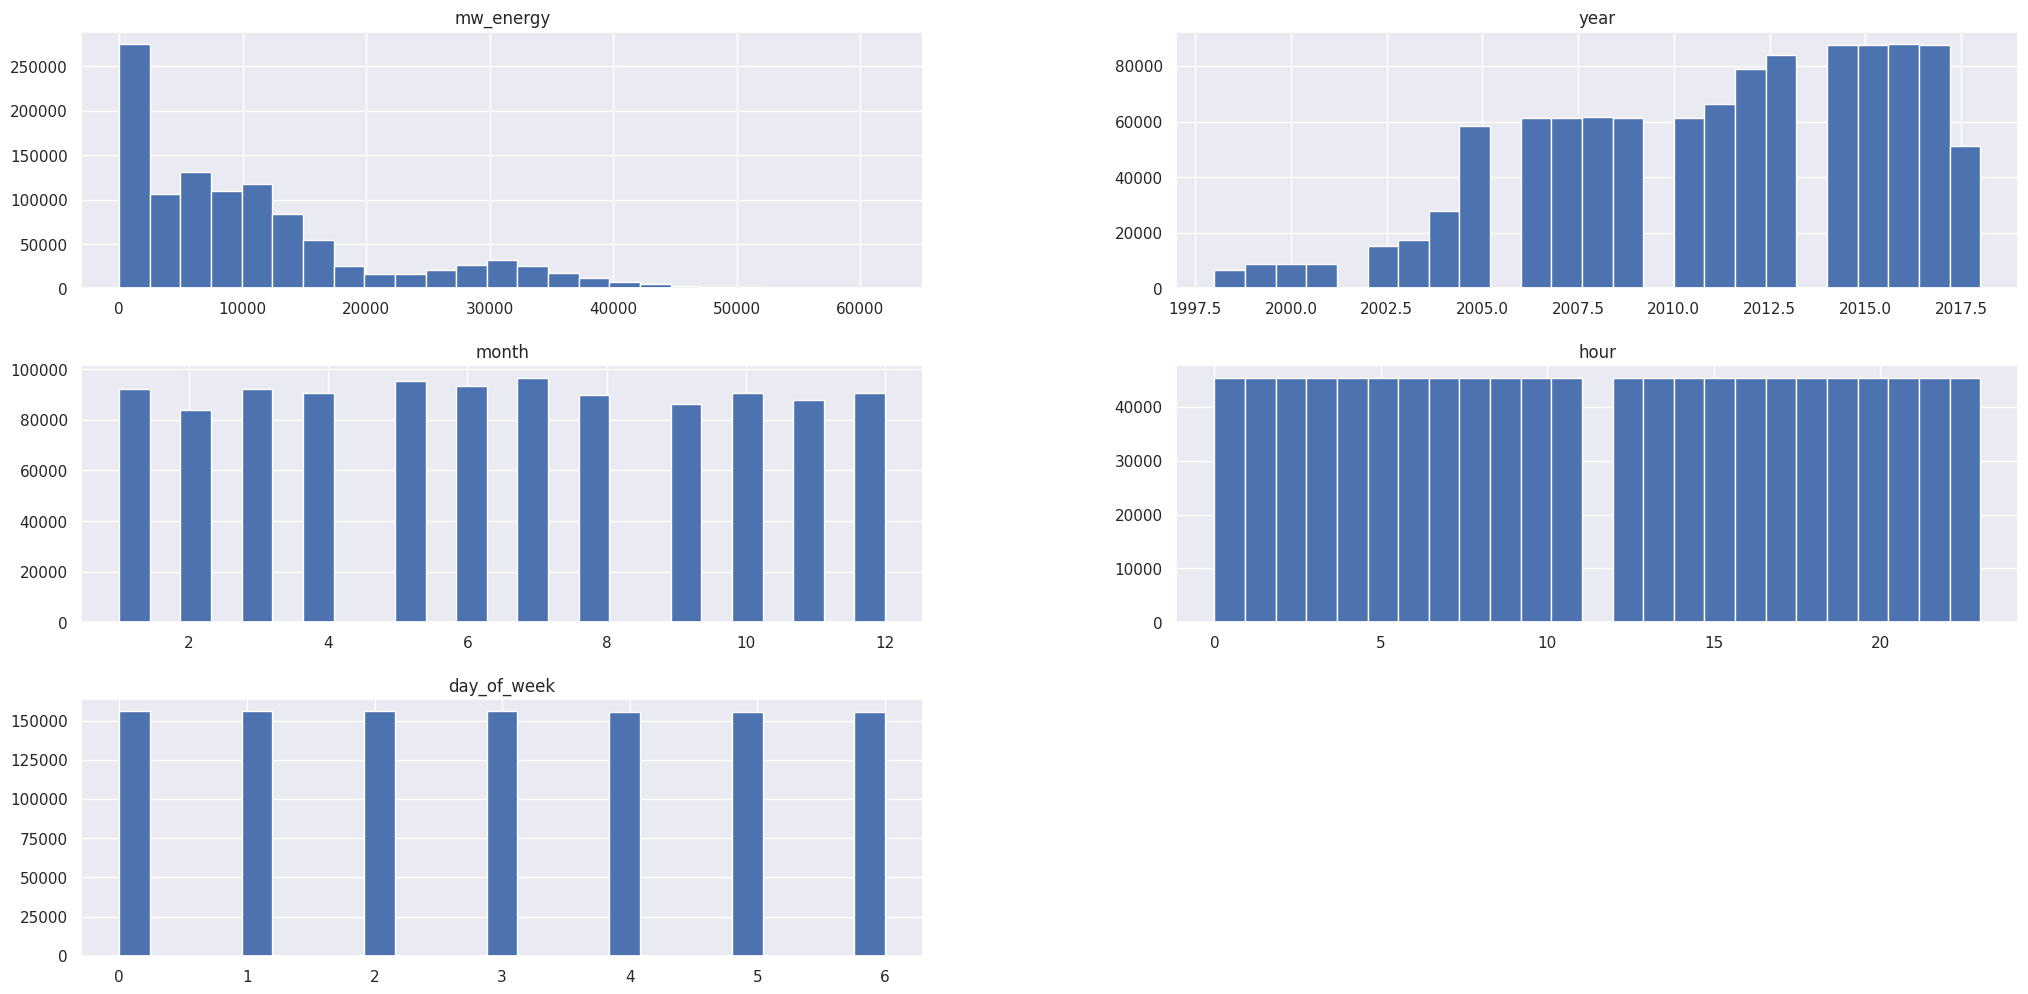

In [53]:
# Exploring distribution of the numerical features
num_features2.hist(bins=25)

In [54]:
# Checking categorical features
cat_features2.head()

,electric_company,season,holidays
0,AEP,Winter,Holiday
1,AEP,Winter,Holiday
2,AEP,Winter,Holiday
3,AEP,Winter,Holiday
4,AEP,Winter,Holiday


In [55]:
# drop duplicates
df_eda['electric_company'].drop_duplicates()

,electric_company
0,AEP
0,COMED
0,DAYTON
0,DEOK
0,DOM
0,DUQ
0,EKPC
0,FE
0,NI
0,PJM


In [56]:
# drop season duplicates
df_eda['season'].drop_duplicates()

,season
0,Winter
744,Autumn
5134,Summer
7342,Spring


In [57]:
# drop holidays duplicates
df_eda['holidays'].drop_duplicates()

,holidays
0,Holiday
48,Normal day


> ▶ Analysing the categorical features and relation to energy consumption

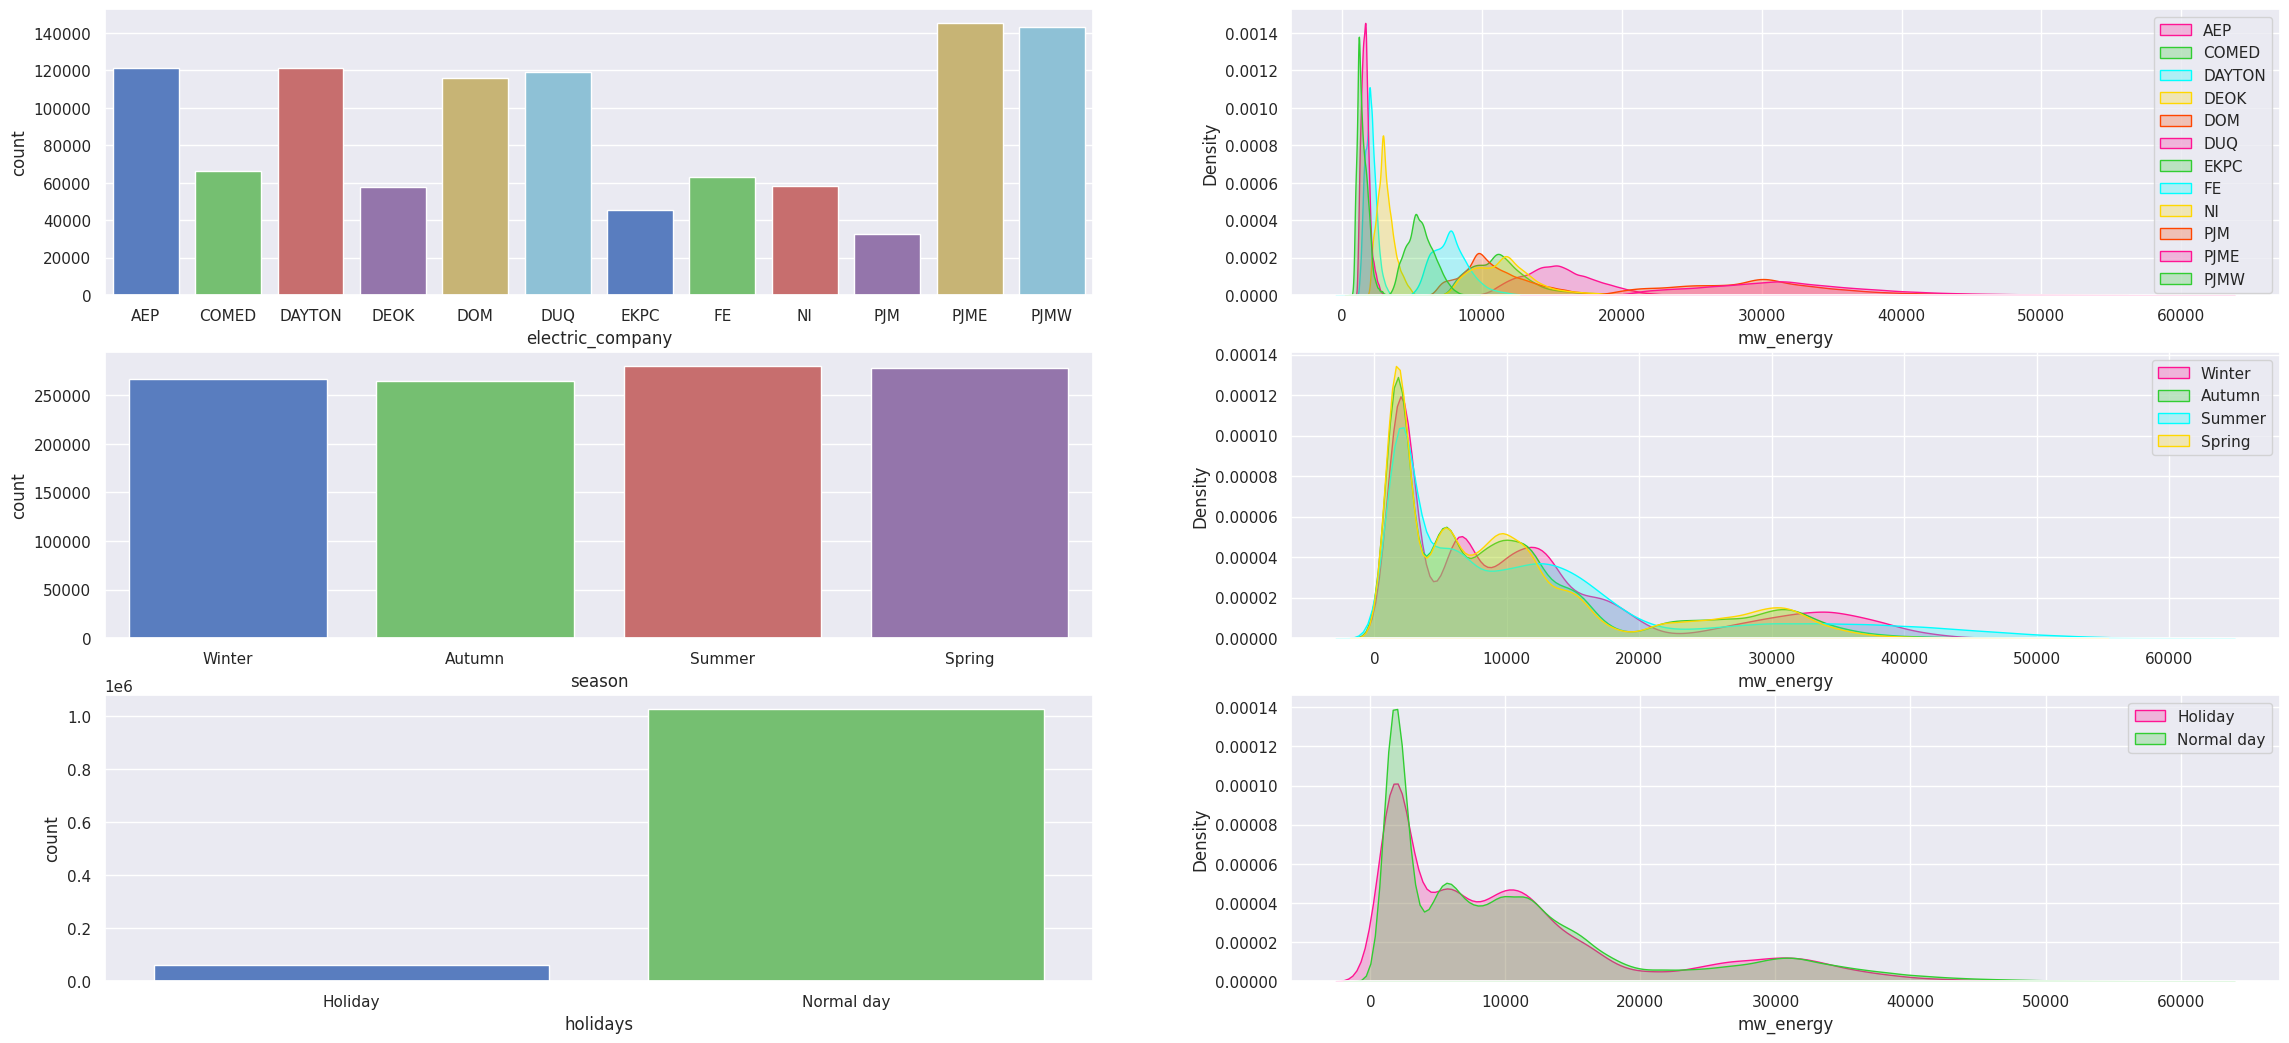

In [89]:
plt.subplot( 3, 2, 1)
sns.countplot( x=df_eda['electric_company'], palette='muted6' )

plt.subplot( 3, 2, 2)
sns.kdeplot( df_eda[df_eda['electric_company'] == 'AEP']['mw_energy'], label='AEP', shade=True )
sns.kdeplot( df_eda[df_eda['electric_company'] == 'COMED']['mw_energy'], label='COMED', shade=True )
sns.kdeplot( df_eda[df_eda['electric_company'] == 'DAYTON']['mw_energy'], label='DAYTON', shade=True )
sns.kdeplot( df_eda[df_eda['electric_company'] == 'DEOK']['mw_energy'], label='DEOK', shade=True )
sns.kdeplot( df_eda[df_eda['electric_company'] == 'DOM']['mw_energy'], label='DOM', shade=True )
sns.kdeplot( df_eda[df_eda['electric_company'] == 'DUQ']['mw_energy'], label='DUQ', shade=True )
sns.kdeplot( df_eda[df_eda['electric_company'] == 'EKPC']['mw_energy'], label='EKPC', shade=True )
sns.kdeplot( df_eda[df_eda['electric_company'] == 'FE']['mw_energy'], label='FE', shade=True )
sns.kdeplot( df_eda[df_eda['electric_company'] == 'NI']['mw_energy'], label='NI', shade=True )
sns.kdeplot( df_eda[df_eda['electric_company'] == 'PJM']['mw_energy'], label='PJM', shade=True )
sns.kdeplot( df_eda[df_eda['electric_company'] == 'PJME']['mw_energy'], label='PJME', shade=True )
sns.kdeplot( df_eda[df_eda['electric_company'] == 'PJMW']['mw_energy'], label='PJMW', shade=True )
plt.legend()
# season

plt.subplot( 3, 2, 3)
sns.countplot( x= df_eda['season'], palette='muted6' )

plt.subplot( 3, 2, 4)
sns.kdeplot( df_eda[df_eda['season'] == 'Winter']['mw_energy'], label='Winter', shade=True )
sns.kdeplot( df_eda[df_eda['season'] == 'Autumn']['mw_energy'], label='Autumn', shade=True )
sns.kdeplot( df_eda[df_eda['season'] == 'Summer']['mw_energy'], label='Summer', shade=True )
sns.kdeplot( df_eda[df_eda['season'] == 'Spring']['mw_energy'], label='Spring', shade=True )
plt.legend()

# holidays
plt.subplot( 3, 2, 5)
sns.countplot( x=df_eda['holidays'], palette='muted6' )

plt.subplot( 3, 2, 6)
sns.kdeplot( df_eda[df_eda['holidays'] == 'Holiday']['mw_energy'], label='Holiday', shade=True )
sns.kdeplot( df_eda[df_eda['holidays'] == 'Normal day']['mw_energy'], label='Normal day', shade=True )

plt.legend()

###  🔦 EDA - Part 2: Bivariate Analysis
- Energy consumption at different times of the day

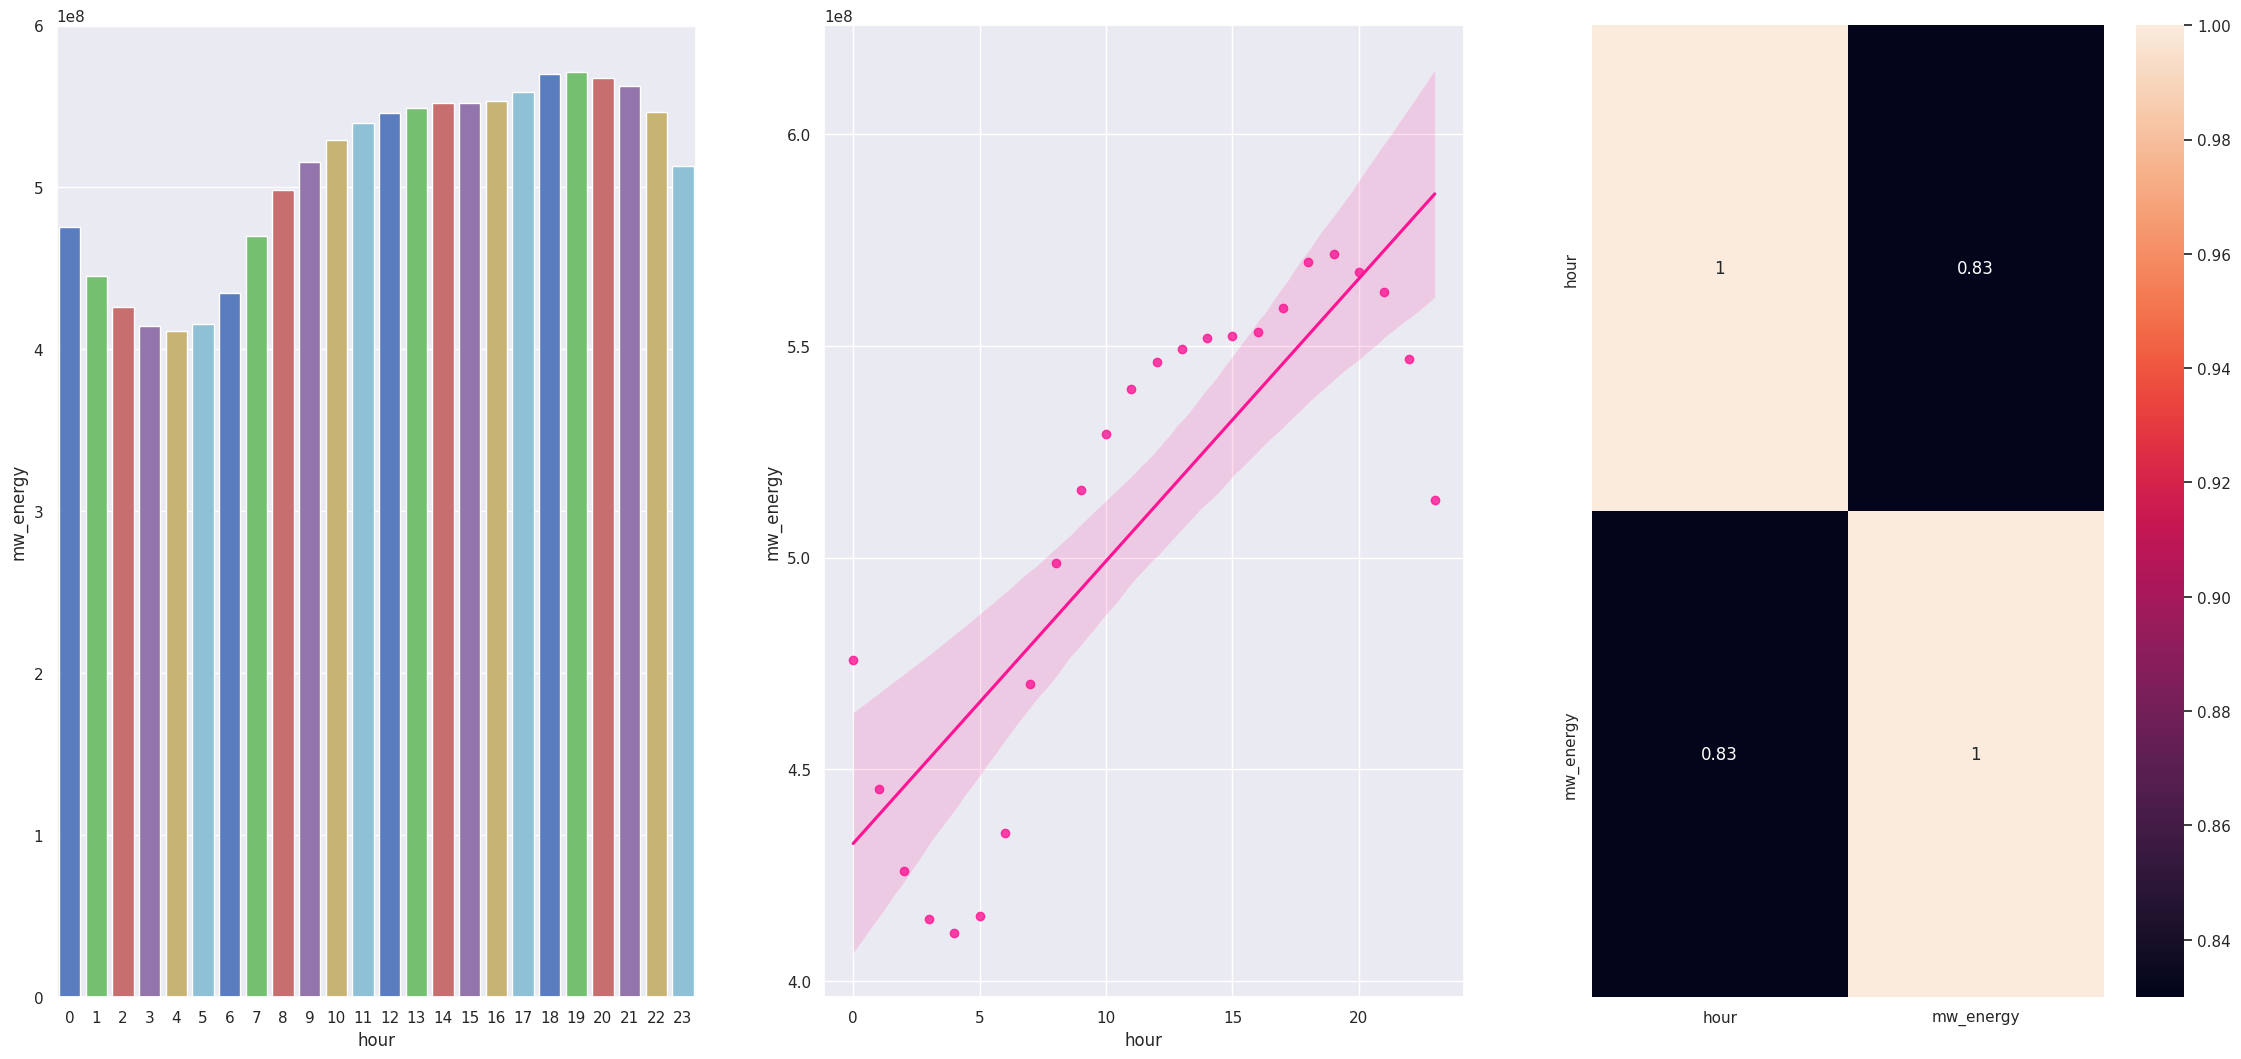

In [92]:
plt.subplot(1,3,1)
d1 = df_eda[['hour', 'mw_energy']].groupby( 'hour' ).sum().reset_index()
sns.barplot( x='hour', y='mw_energy', data=d1, palette='muted6')

plt.subplot(1,3,2)
sns.regplot( x='hour', y='mw_energy', data=d1 )

plt.subplot(1,3,3)
sns.heatmap( d1.corr( method='pearson' ), annot=True );

#### 💡 Observations and Inference:
> - From the bar plot on the left we seee that energy consumption peaks early morning and rises to its peak around the evening hours
> - Least energy consumption is witnessed during post midnight
> - The regression plot and pearson correlation show a strong positive correlation between the hour of the day and the energy consumptions

#### 🎯 Energy consumption across seasons

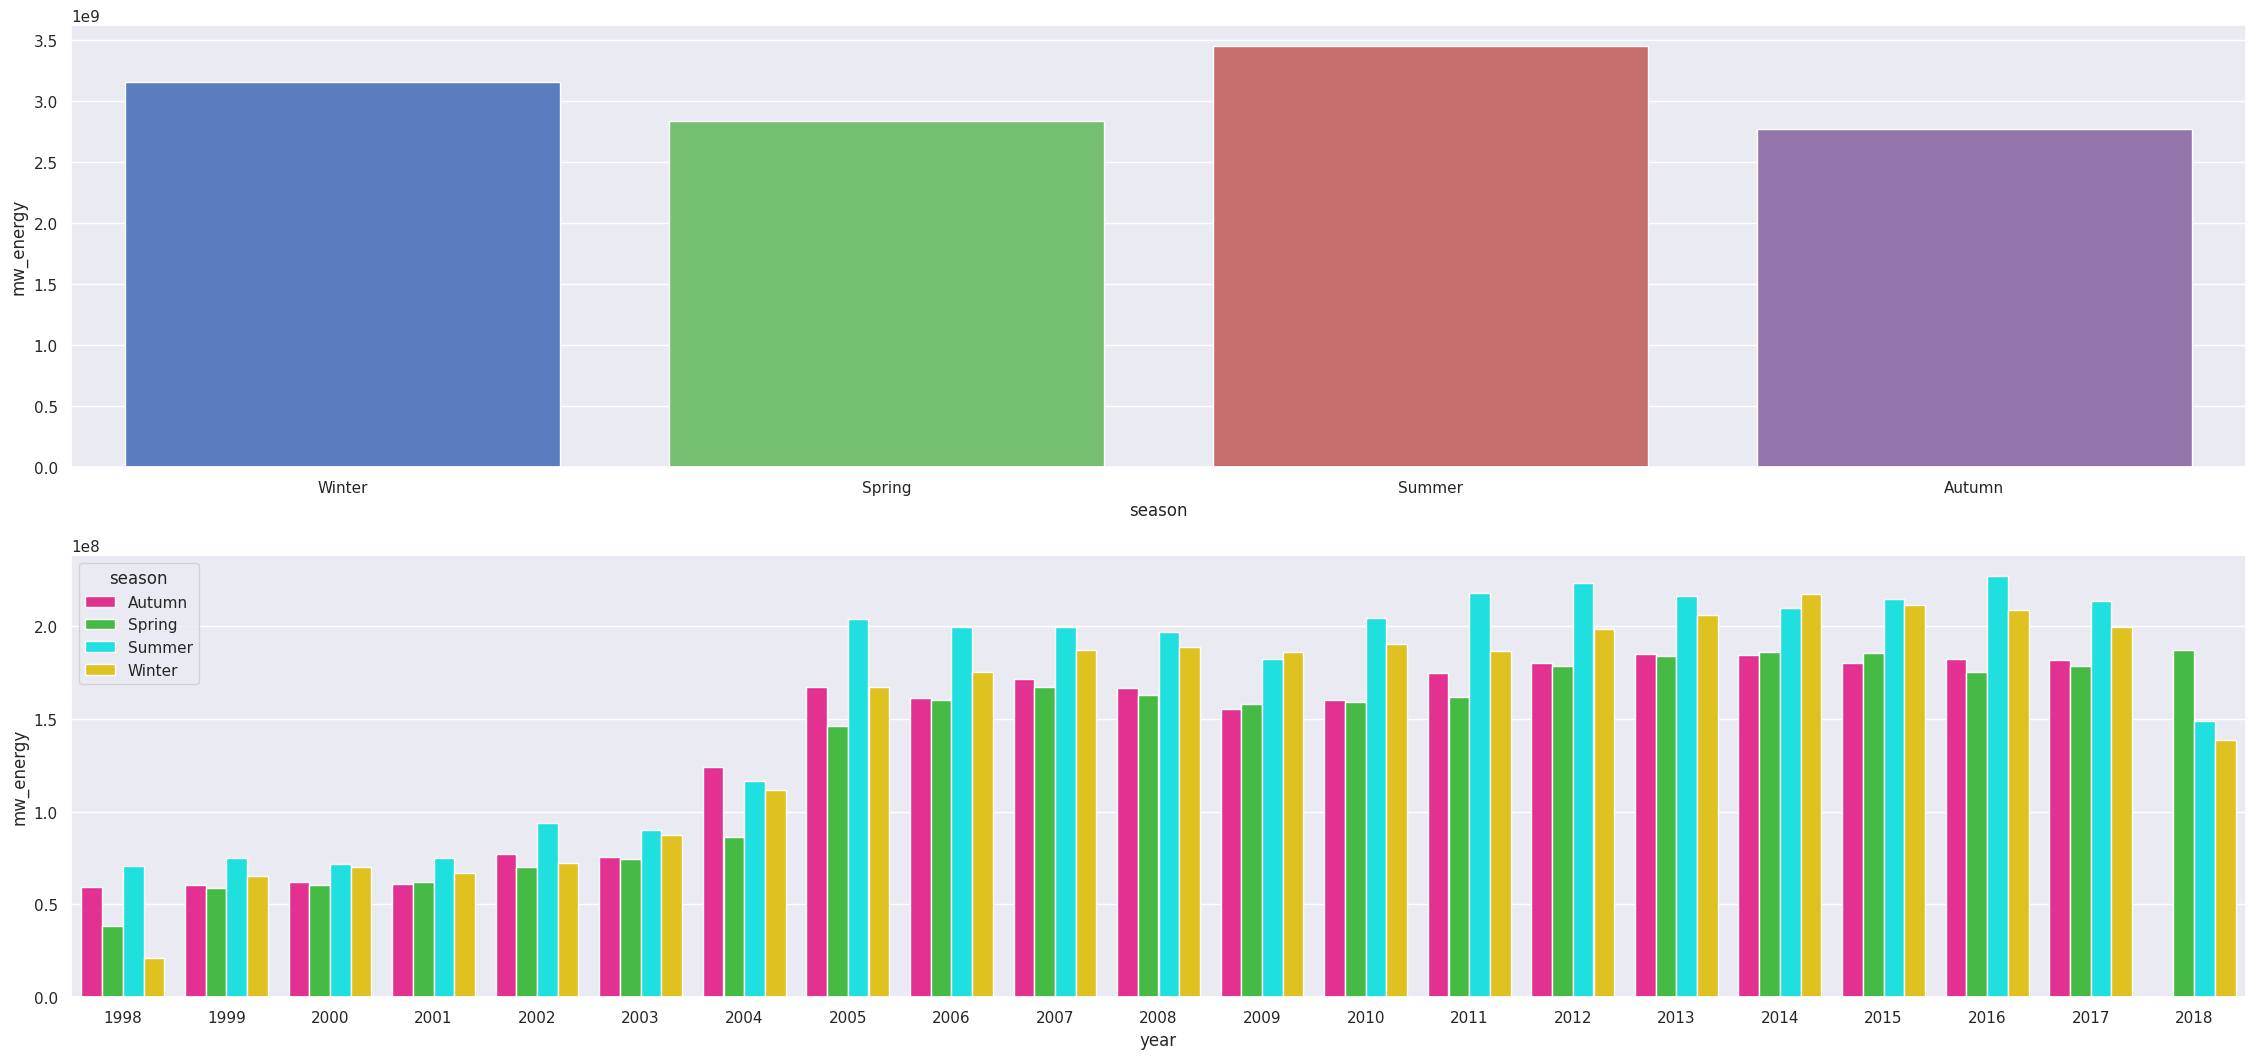

In [95]:
d1 = df_eda[['season', 'mw_energy']].groupby( 'season' ).sum().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='season', y='mw_energy', data=d1, order=['Winter', 'Spring', 'Summer', 'Autumn'], palette='muted6' )

d2 = df_eda[['year', 'season', 'mw_energy']].groupby( ['year', 'season'] ).sum().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='year', y='mw_energy', hue='season', data=d2, orient='v');

#### 💡 Observations and Inference:
> * Energy consumption is highest during winters and summers across the datasets
> * The rise of energy demands becomes very evdient when we spread out the seasonal energy consumption over the years from 1998 to 2018

#### 🎯 Energy consumption across federal holidays


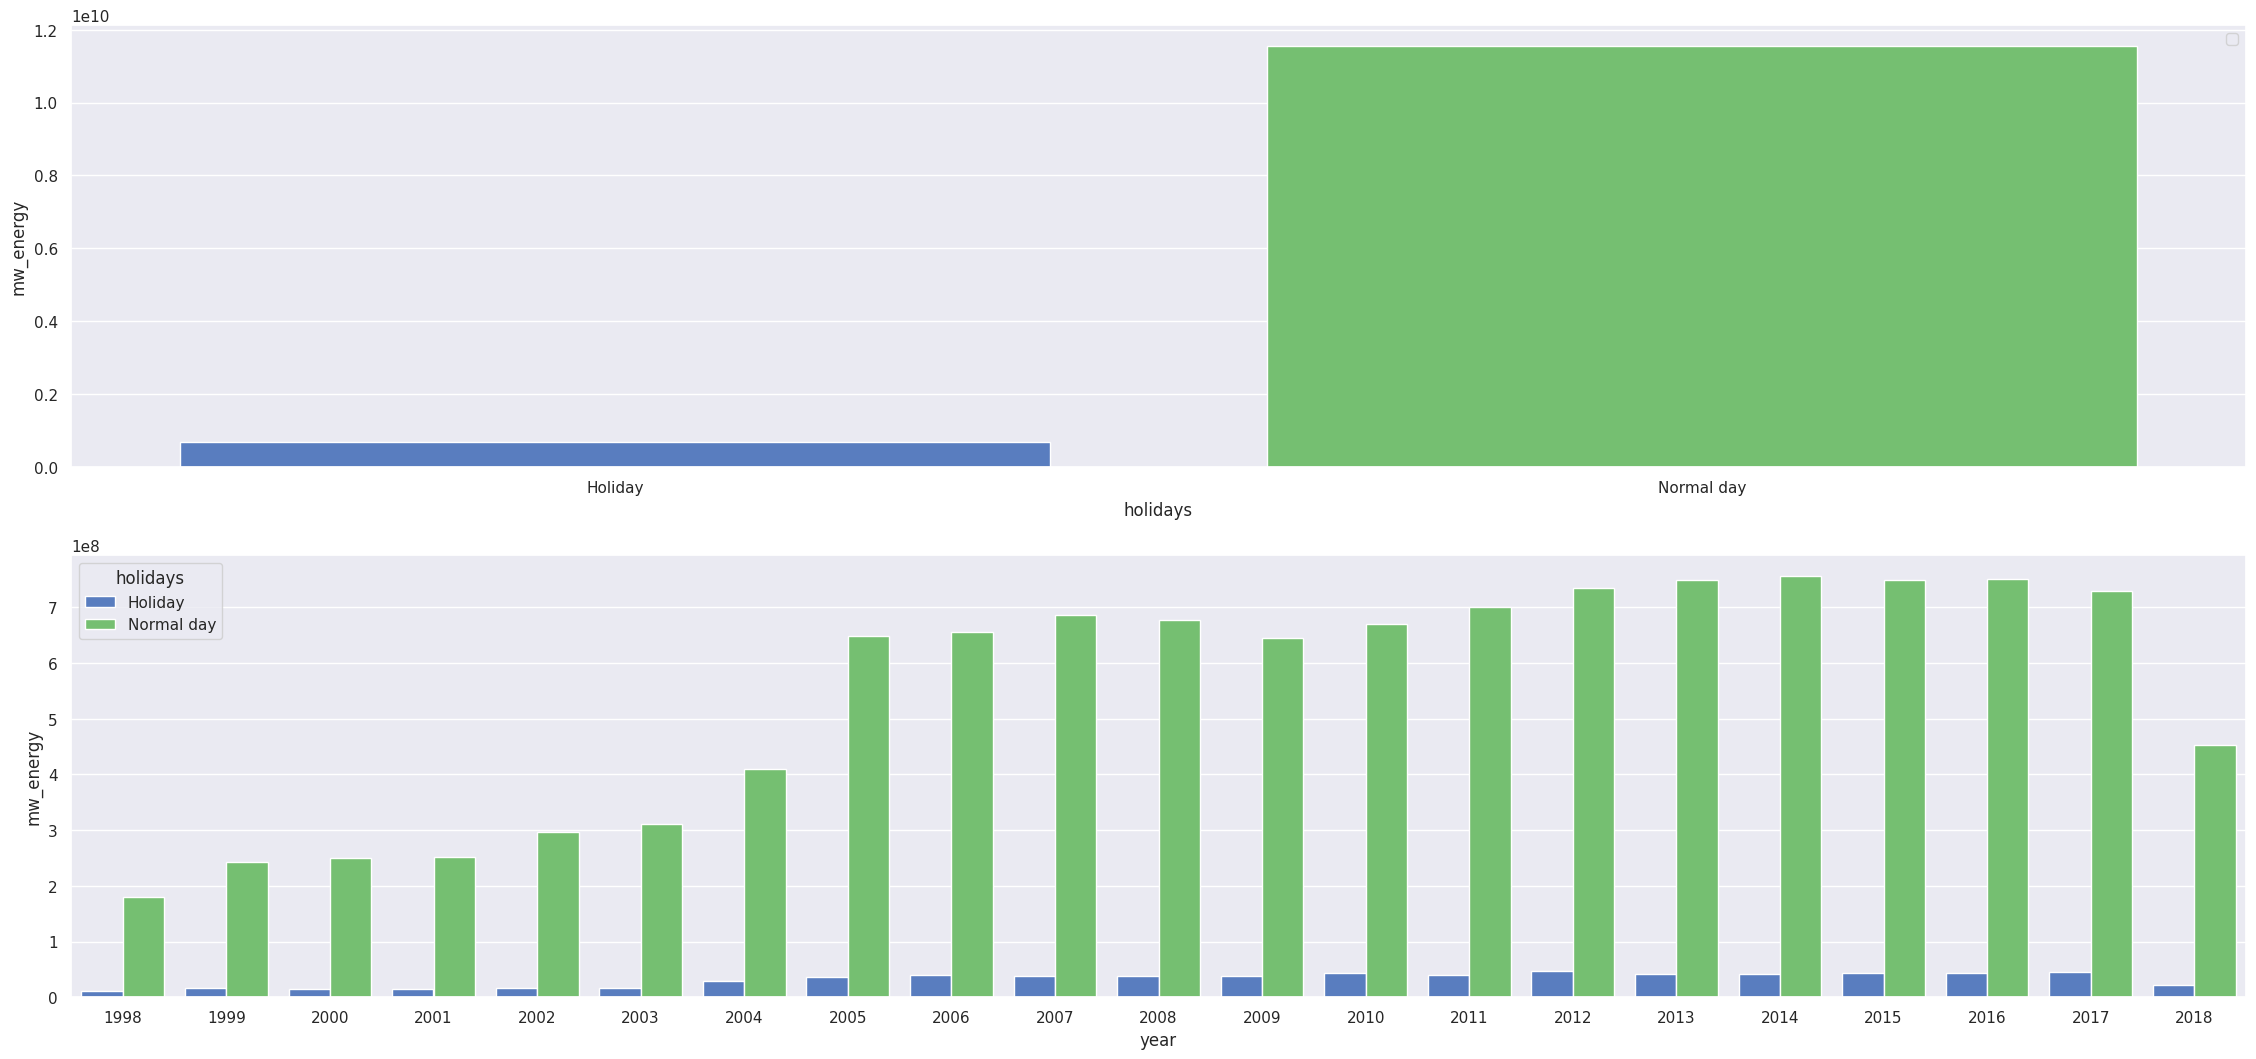

In [98]:
d1 = df_eda[['holidays', 'mw_energy']].groupby( 'holidays' ).sum().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='holidays', y='mw_energy', data=d1, palette='muted6' )
plt.legend()

d2 = df_eda[['year', 'holidays', 'mw_energy']].groupby( ['year', 'holidays'] ).sum().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='year', y='mw_energy', hue='holidays', data=d2, palette='muted6' );

#### 💡 Observations and Inference:
> * Energy consumption contrary to usual hypothesis is much higher during workdays then holidays
> * Here too when we plot this distribution across the years we see how significant workday energy consumption is compared to holidays.
> * An intersting Article [Holiday Power Consumption](https://www.eia.gov/todayinenergy/detail.php?id=37572&src=email) that verifies the analysis further

###  🔦 EDA - Part 3: Multivariate Analysis

#### 🎯 Energy consumption correlation across all the numerical time series features

<Axes: >

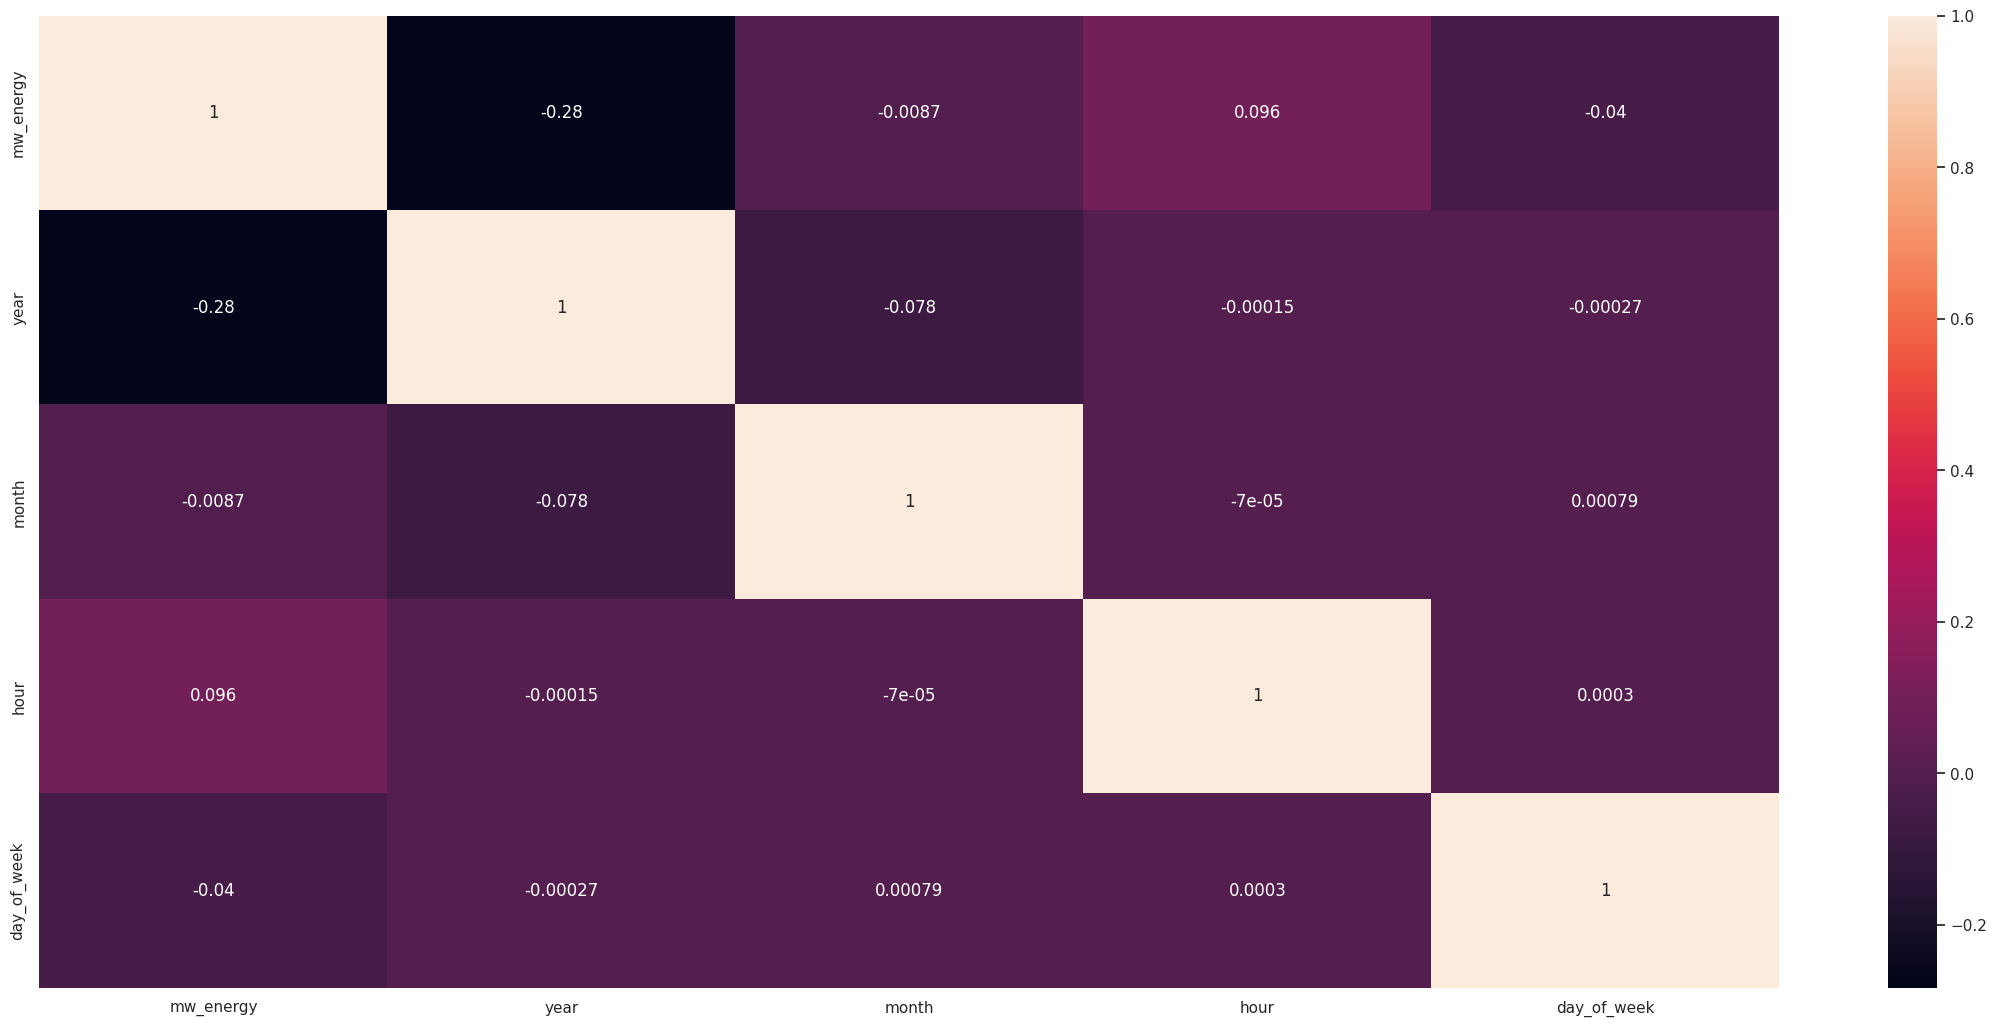

In [99]:
correlation = num_features2.corr( method='pearson' )
sns.heatmap( correlation, annot=True )


#### 💡 Observations and Inference:
> * Year and month don't seem to have a strong relationship with energy consumption

#### 🎯 Energy consumption correlation across all the categorical time series features

* Below code creates the contingency table using cross tab

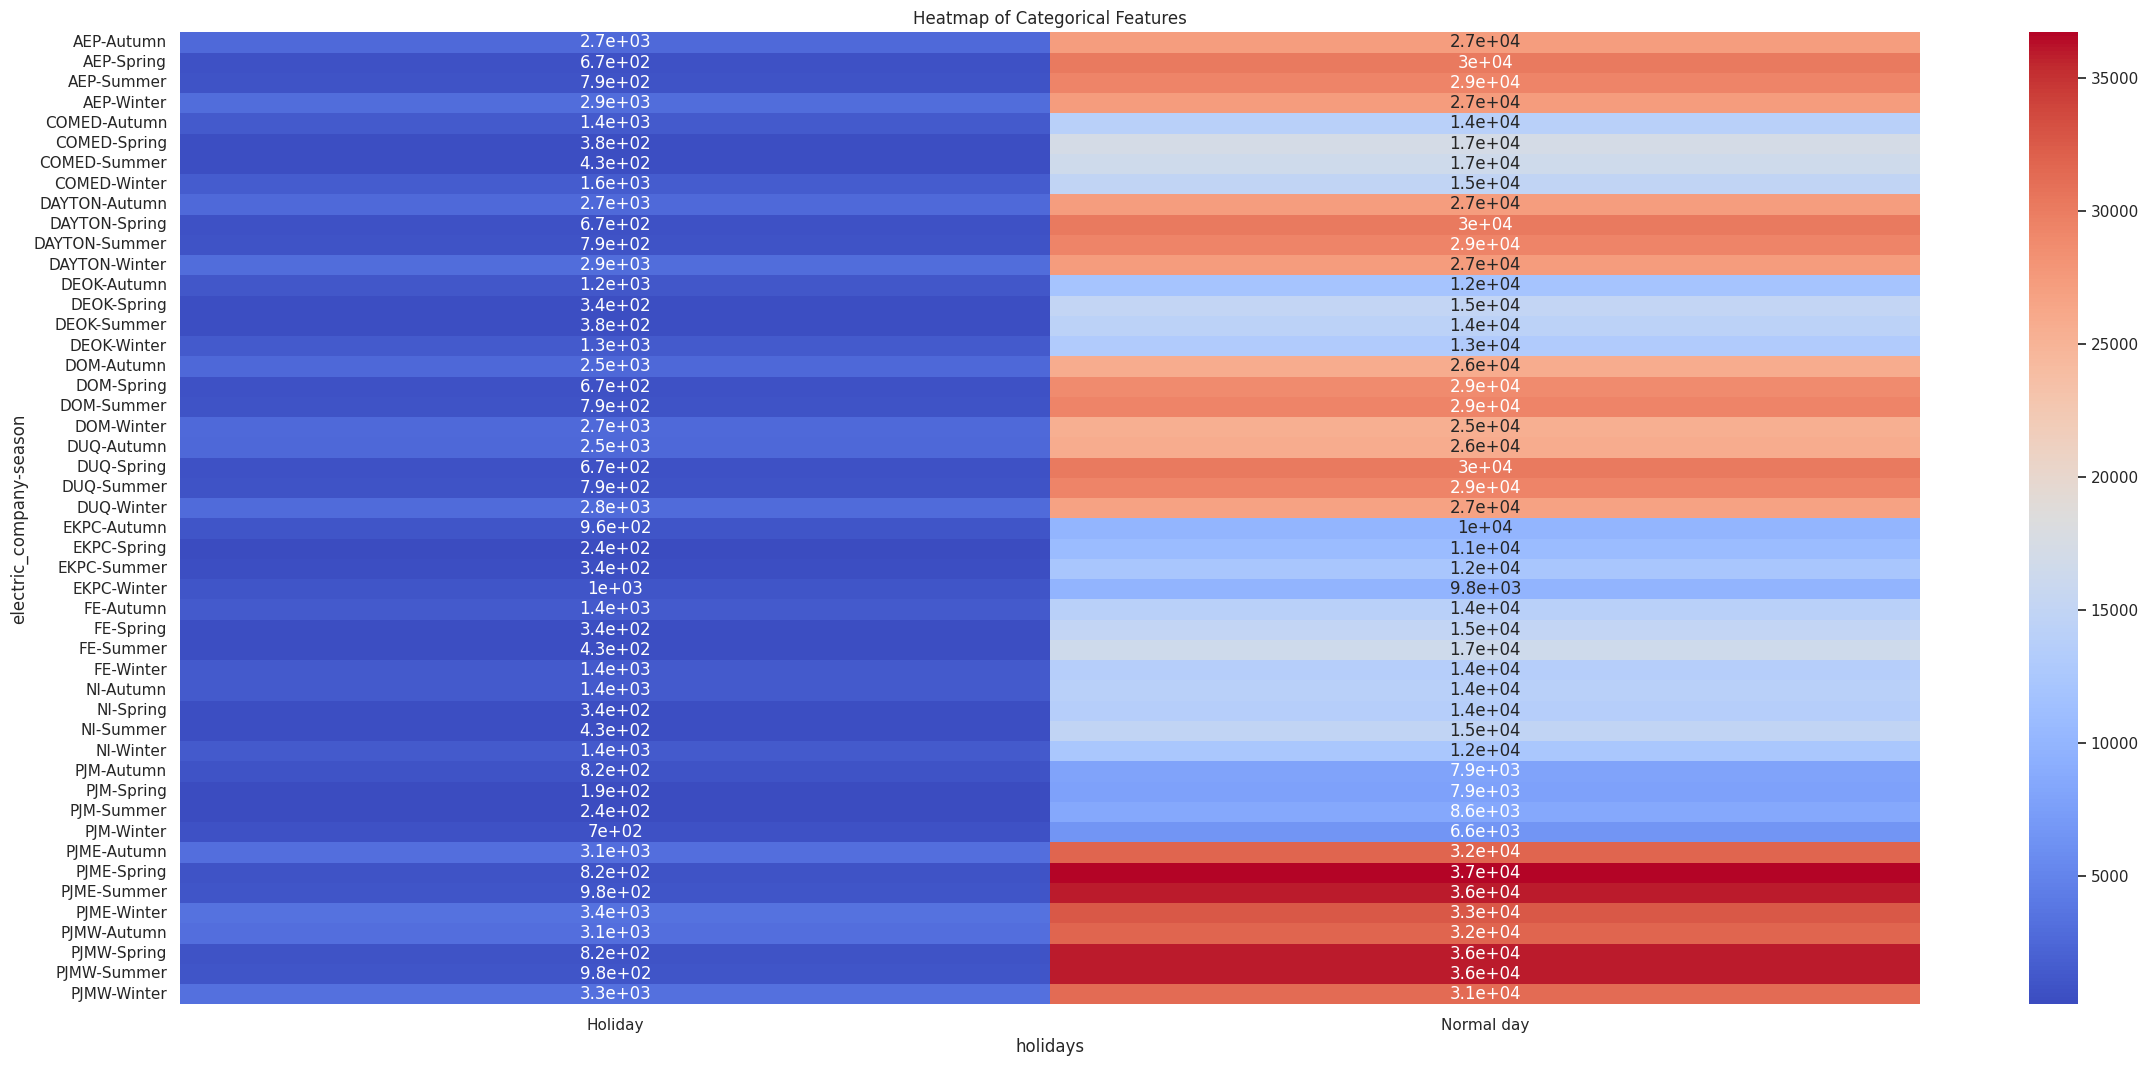

In [123]:
# Create a contingency table
contingency_table = pd.crosstab(index=[cat_features2['electric_company'],cat_features2['season']], columns=cat_features2['holidays'])

# Plot the heatmap
sns.heatmap(contingency_table, annot=True, cmap='coolwarm')
plt.title("Heatmap of Categorical Features")
plt.show()

 ## 📉 3. Predictive Modeling